In [1]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *
from plot_utils import *
from tqdm import tqdm

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
# os.chdir("/data/tianyu_guo/birth")
from data import DataArgs, Dataset, iterate_batches, make_dataset
from ihead_full_model import *

%load_ext autoreload
%autoreload 2


In [2]:
torch.cuda.set_device(4)
device = 'cuda:4'
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/check_lr"
no_attn = ( )

model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=no_attn, no_ffn=(), linear_ffn=(), lr=0.003, use_simple_model=False, use_vo=True, with_data=True, with_optim=True, data_path_local=None, data_path_server="/data/tianyu/birth/data", device=device)

In [3]:
model_loader.change_steps(1000)
model, cfg, x, y, ds, optim = model_loader(with_data=True)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))

/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [12]:
hook = forward_hook([], "")
bos_norms = {}
tok_norms = {}
for step in tqdm(torch.arange(0, 10001, 20).tolist()):
    model_loader.change_steps(step)
    model, cfg, optim = model_loader(with_data=False)
    _, outputs_list = model.modified_forward_with_hook(x, hook)
    bos_norms[step] = outputs_list[0]['output'][0, 0, :].norm(dim=-1).item()
    tok_norms[step] = outputs_list[0]['output'][0, 1, :].norm(dim=-1).item()


100%|██████████| 501/501 [00:54<00:00,  9.22it/s]


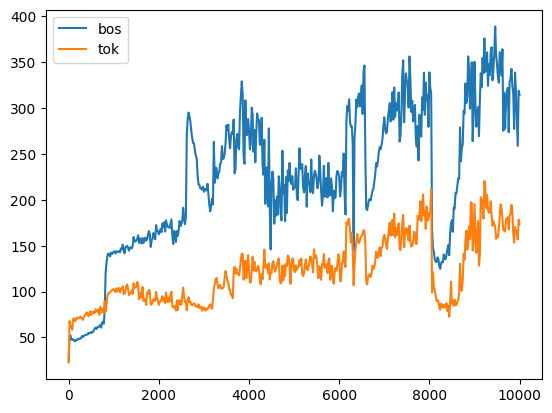

In [13]:
plt.plot(bos_norms.keys(), bos_norms.values(), label='bos')
plt.plot(tok_norms.keys(), tok_norms.values(), label='tok')
plt.legend()
plt.show()